In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import re
import string
from wordcloud import WordCloud

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Only keep 10 000 words
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 9s 1us/step


In [4]:
# Get the word index mapping words to integers
word_index = imdb.get_word_index()

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 2s 1us/step


In [5]:
# Create reverse mapping from int to word
index_word = {v+3:k for k,v in word_index.items()}  # offset by 3
index_word[0] = '<PAD>'
index_word[1] = '<START>'
index_word[2] = '<UNK>'
index_word[3] = '<UNUSED>'

In [6]:
# Function to decode reviews back to text
def decode_review(encoded_review):
    return ' '.join([index_word.get(i, '?') for i in encoded_review])

In [7]:
# Decode all reviews back to text
X_train_text = [decode_review(review) for review in X_train]
X_test_text = [decode_review(review) for review in X_test]

In [11]:
# 2. Create DataFrame for easier handling & EDA
# -------------------
df_train = pd.DataFrame({'review': X_train_text, 'label': y_train})
df_test = pd.DataFrame({'review': X_test_text, 'label': y_test})

In [13]:
df_train.head()

,review,label
0,<START> this film was just brilliant casting l...,1
1,<START> big hair big boobs bad music and a gia...,0
2,<START> this has to be one of the worst films ...,0
3,<START> the <UNK> <UNK> at storytelling the tr...,1
4,<START> worst mistake of my life br br i picke...,0


In [15]:
df_train.tail()

,review,label
24995,<START> this is a racist movie but worthy of s...,1
24996,<START> bela lugosi plays a doctor who will do...,0
24997,<START> in a far away galaxy is a planet calle...,0
24998,<START> six degrees had me hooked i looked for...,1
24999,<START> as a big fan of the original film it's...,0


In [16]:
# 3. Data Cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # remove HTML tags if any
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove non-alpha chars
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [17]:
df_train['clean_review'] = df_train['review'].apply(clean_text)
df_test['clean_review'] = df_test['review'].apply(clean_text)


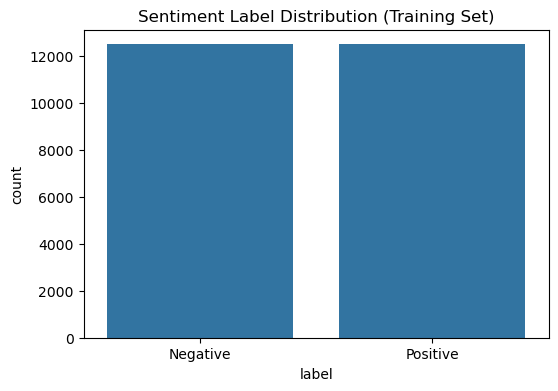

In [18]:
# 4. Exploratory Data Analysis

# Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df_train, x='label')
plt.title('Sentiment Label Distribution (Training Set)')
plt.xticks([0,1], ['Negative', 'Positive'])
plt.show()

In [20]:
# WordCloud for positive and negative reviews
def plot_wordcloud(text, title):
    wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

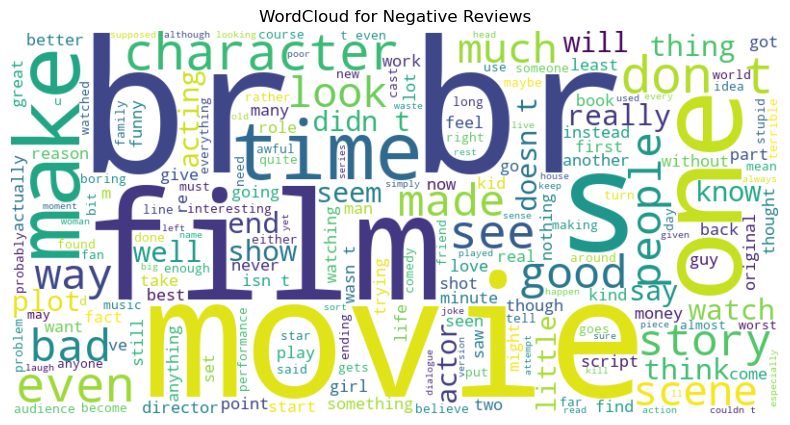

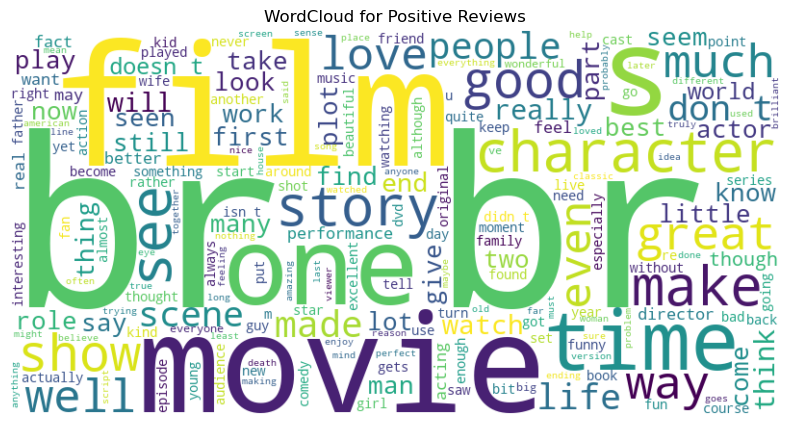

In [21]:
plot_wordcloud(df_train[df_train['label']==0]['clean_review'], 'WordCloud for Negative Reviews')
plot_wordcloud(df_train[df_train['label']==1]['clean_review'], 'WordCloud for Positive Reviews')

In [22]:
# 5. Vectorize text with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(df_train['clean_review'])
X_test_tfidf = vectorizer.transform(df_test['clean_review'])

y_train = df_train['label'].values
y_test = df_test['label'].values

In [ ]:
# 6. Train Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [24]:
# 7. Evaluate model
y_pred = model.predict(X_test_tfidf)
y_probs = model.predict_proba(X_test_tfidf)[:,1]

In [25]:
y_pred

array([0, 1, 1, ..., 0, 0, 0], dtype=int64)

In [26]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



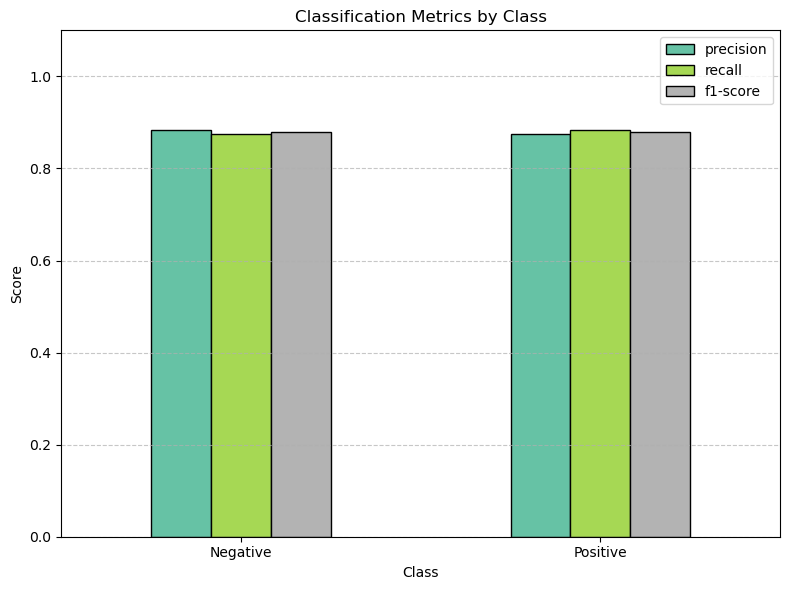

In [31]:
# Grouped bar plot for classification report
report_df_plot = report_df[["precision", "recall", "f1-score"]].copy()
report_df_plot.index.name = 'Class'

report_df_plot.plot(
    kind='bar',
    figsize=(8, 6),
    colormap='Set2',
    edgecolor='black'
)
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


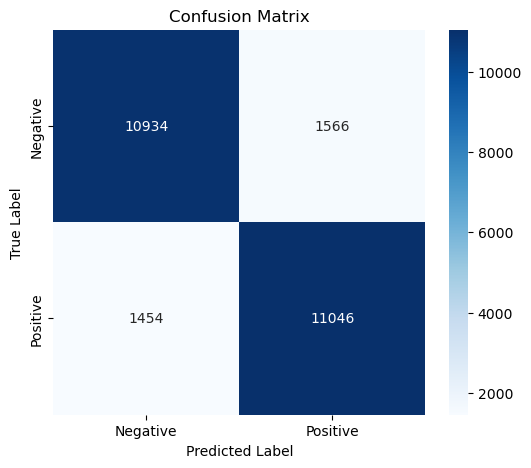

In [27]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

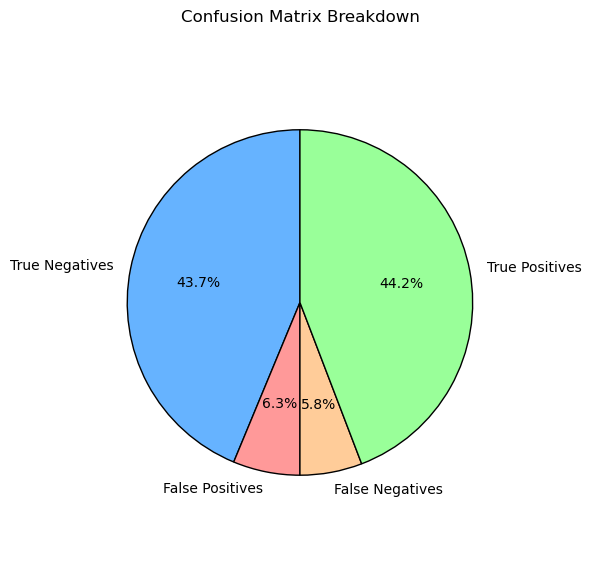

In [32]:
# Reuse confusion matrix
cm = confusion_matrix(y_test, y_pred)

tn, fp, fn, tp = cm.ravel()

labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
sizes = [tn, fp, fn, tp]
colors = ['#66b3ff', '#ff9999', '#ffcc99', '#99ff99']

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(edgecolor='black')
)
plt.title('Confusion Matrix Breakdown')
plt.axis('equal')
plt.tight_layout()
plt.show()


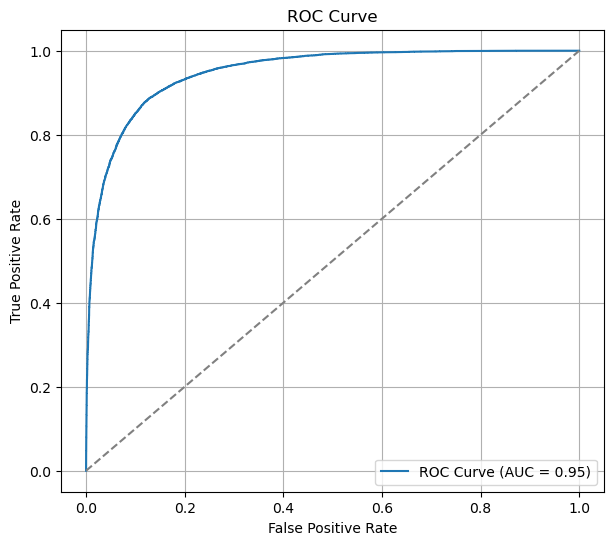

In [28]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
import joblib

# Save the vectorizer and model
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(model, 'sentiment_model.pkl')


['sentiment_model.pkl']

In [34]:
# Load the saved model and vectorizer for prediction
vectorizer = joblib.load('tfidf_vectorizer.pkl')
model = joblib.load('sentiment_model.pkl')

# Sample prediction
sample_text = "This movie was absolutely amazing and heartfelt."
clean_text = clean_text(sample_text)  # reuse your cleaning function
X_sample = vectorizer.transform([clean_text])
pred = model.predict(X_sample)

print("Prediction:", "Positive" if pred[0] == 1 else "Negative")


Prediction: Positive


In [37]:
!curl -X POST http://localhost:5000/predict -H "Content-Type: application/json" -d '{"text":"This was a fantastic movie!"}'


'curl' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
from flask import Flask, request, jsonify
import joblib

app = Flask(__name__)

vectorizer = joblib.load('tfidf_vectorizer.pkl')
model = joblib.load('sentiment_model.pkl')

def clean_text(text):
    import re, string
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    text = data['text']
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    prediction = model.predict(vec)[0]
    return jsonify({'prediction': int(prediction)})

if __name__ == '__main__':
    app.run(debug=True)
